# Imports

In [1]:
from ebay_delivery_prediction_project import preprocessing, Visualisation, preprocessing_models, postprocessing
preprocessing.import_test()
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta

Preprocessing successfully imported.


In [2]:
# data_object = Preprocessing.read_data(rows_to_read = None, columns = ["b2c_c2c"])
# data_object = Preprocessing.read_data(rows_to_read = None)
N = 100000
training_data = preprocessing.read_data(rows_to_read = N)["train"]
print(training_data.columns)
print(len(training_data.columns))

Reading 100000 rows.
Reading all columns.
Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number'],
      dtype='object')
19


# Setting up pipeline

## Target column

The objective is to estimate the total number of calendar days (after payment) it will take to have a purchased item show up at the buyer’s address. This is equivalent to estimating the delivery date using the formula:

payment date (local time) + delivery calendar days = delivery date (local time).

Participants should provide this delivery date in their submissions.

_Now to generate target column_

### Preprocessing the datetime columns

In [3]:
training_data = preprocessing.parse_datetime_columns(training_data)

### Generating target column "delivery_calendar_days"

In [4]:
training_data = preprocessing.create_delivery_calendar_days(training_data)

In [5]:
training_data["delivery_date"].describe()

/home/swagget/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  100000
unique                    667
top       2018-12-17 00:00:00
freq                      372
first     2018-01-02 00:00:00
last      2019-12-18 00:00:00
Name: delivery_date, dtype: object

In [6]:
for col in training_data.columns:
    print(f"{col} : {len(training_data[col].unique())}")

b2c_c2c : 2
seller_id : 57971
declared_handling_days : 11
acceptance_scan_timestamp : 88902
shipment_method_id : 17
shipping_fee : 1700
carrier_min_estimate : 6
carrier_max_estimate : 6
item_zip : 16089
buyer_zip : 19592
category_id : 33
item_price : 6518
quantity : 28
payment_datetime : 99878
delivery_date : 667
weight : 318
weight_units : 1
package_size : 5
record_number : 100000
delivery_calendar_days : 82


# Implementing pipeline

## Arbitrarily choosing how to encode columns

In [7]:
different_types_of_encoding = ["one-hot", "numerical"]

cols_and_encoding = {
    "b2c_c2c"   : "one-hot",
    "seller_id"   : 6365,
    "declared_handling_days"   : "numerical",
    "acceptance_scan_timestamp"   : 9848,
    "shipment_method_id"   : "one-hot",
    "shipping_fee"   : "numerical",
    "carrier_min_estimate"   : 4, # Cheating?
    "carrier_max_estimate"   : 5, # Cheating?
    "item_zip"   : 4701, # Needs a lot of preprocessing.
    "buyer_zip"   : 6880, # Needs a lot of preprocessing.
    "category_id"   : 'one-hot', # Only has 33 unique values in 15,000,000 rows so one-hot.
    "item_price"   : "numerical",
    "quantity"   : "numerical",
    "payment_datetime"   : 9998,
    "delivery_date"   : 602,
    "weight"   : "numerical",
    "weight_units"   : 1,
    "package_size"   : "one-hot",
    "record_number"   : 10000,
    "delivery_calendar_days"   : "target",
}

In [8]:
cols_to_convert_to_one_hot = [ele for ele in cols_and_encoding.keys() if cols_and_encoding[ele] == "one-hot"]

print("cols_to_convert_to_one_hot : ", cols_to_convert_to_one_hot)

print("training_data.shape before : ", training_data.shape)
training_data, generated_columns = preprocessing.one_hot_encode_columns(df = training_data, columns = cols_to_convert_to_one_hot)
print("training_data.shape after : ", training_data.shape)

cols_to_convert_to_one_hot :  ['b2c_c2c', 'shipment_method_id', 'category_id', 'package_size']
training_data.shape before :  (100000, 20)
training_data.shape after :  (100000, 73)


In [9]:
target_column = "delivery_calendar_days"
cols_to_use = [ele for ele in cols_and_encoding.keys() if (type(cols_and_encoding[ele]) == str) and
               (cols_and_encoding[ele] != "target") and
               (cols_and_encoding[ele] != "one-hot")]
cols_to_use = [*cols_to_use, *generated_columns]

## Running a gradient boosted decision tree model

In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math
import numpy as np

In [12]:
# I have tweaked the objective function based on our needs

In [13]:
def customLossFunctionEval(y_true, y_pred):
    residual = (y_true - y_pred).astype(np.float32)
    loss = np.where(residual < 0, 0.4 * (residual ** 2), 0.6 * (residual ** 2))
    return "Custom Loss Function", np.mean(loss), False

In [14]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*0.4*residual, -2*0.6*residual)
    hess = np.where(residual<0, 2*0.4, 2.0)
    return grad, hess

In [24]:
def custom_symmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*0.5*residual, -2*0.5*residual)
    hess = np.where(residual<0, 2*0.5, 2.0)
    return grad, hess

In [25]:
# To define the input and output feature
# x = training_data.drop(['Embarked','PassengerId'],axis=1)
x = training_data[cols_to_use]
y = training_data[target_column]
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((67000, 62), (33000, 62), (67000,), (33000,))

In [42]:
# I have changed the lr, early_stopping_rounds and n_estimators
model = lgb.LGBMRegressor(learning_rate=0.03,max_depth=-5,random_state=42,early_stopping_rounds = 10,n_estimators=100)
model.set_params(**{'objective': custom_symmetric_objective})
# model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
#           verbose=10,eval_metric='l2')# This loss needs to mirror the loss that Ebay is using.

LGBMRegressor(early_stopping_rounds=10, learning_rate=0.03, max_depth=-5,
              objective=<function custom_symmetric_objective at 0x7f3fcc41b710>,
              random_state=42)

In [43]:
model.fit(x_train,y_train,eval_set=[(x_test,y_test)],
          verbose=False,eval_metric=customLossFunctionEval)

/home/swagget/anaconda3/envs/py37/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


LGBMRegressor(early_stopping_rounds=10, learning_rate=0.03, max_depth=-5,
              objective=<function custom_symmetric_objective at 0x7f3fcc41b710>,
              random_state=42)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

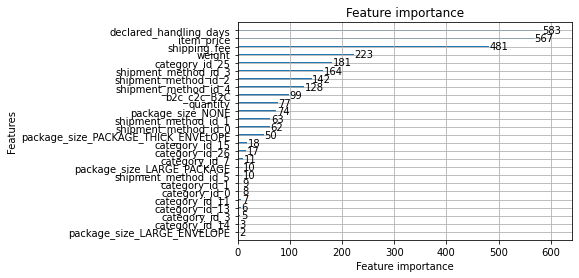

In [44]:
lgb.plot_importance(model)

In [38]:
# Error metrics
y_predicted = model.predict(x_test)
print('MSE', mean_squared_error(y_test, y_predicted))
print('RMSE', math.sqrt(mean_squared_error(y_test, y_predicted)))
print('MAE', mean_absolute_error(y_test, y_predicted))

MSE 7.816331348051269
RMSE 2.7957702602415795
MAE 1.5173387373555884


In [46]:
# Error metrics
print("This is if you make it a custom symmetric function then check all the losses.")
y_predicted = model.predict(x_test)
print('MSE', mean_squared_error(y_test, y_predicted))
print('RMSE', math.sqrt(mean_squared_error(y_test, y_predicted)))
print('MAE', mean_absolute_error(y_test, y_predicted))

This is if you make it a custom symmetric function then check all the losses.
MSE 8.42535327230675
RMSE 2.9026459088746512
MAE 1.5751832422816343


In [47]:
total_under = 0
total_over = 0
perfect = 0
print("This is if you make it a custom symmetric function then check all the errors.\
      This is weird becayse if the massive imbalance. \
      It could possibly be caused because of some outliers skewing the data.")

for pred, actual in zip(y_predicted, y_test):
    if pred<actual:
        total_under += 1
    elif pred>actual:
        total_over += 1
    else:
        perfect += 1
        
print(f"\
total_under = {total_under}\n\
total_over = {total_over}\n\
perfect = {perfect}\n")

This is if you make it a custom symmetric function then check all the errors.      This is weird becayse if the massive imbalance.       It could possibly be caused because of some outliers skewing the data.
total_under = 20248
total_over = 12752
perfect = 0



In [51]:
arr = np.array(y_predicted)
 
# measures of central tendency
mean = np.mean(arr)
median = np.median(arr)
 
# measures of dispersion
min = np.amin(arr)
max = np.amax(arr)
range = np.ptp(arr)
variance = np.var(arr)
sd = np.std(arr)

print("Descriptive analysis")
print("Array =", arr)
print("Measures of Central Tendency")
print("Mean =", mean)
print("Median =", median)
print("Measures of Dispersion")
print("Minimum =", min)
print("Maximum =", max)
print("Range =", range)
print("Variance =", variance)
print("Standard Deviation =", sd)

Descriptive analysis
Array = [3.41432722 3.41432722 3.92146694 ... 4.29908626 3.41591496 3.22238834]
Measures of Central Tendency
Mean = 3.8246206933734026
Median = 3.4414597638361055
Measures of Dispersion
Minimum = 3.1693926625923874
Maximum = 27.392777310510066
Range = 24.22338464791768
Variance = 0.772650984944285
Standard Deviation = 0.8790056796996735


In [45]:
total_under = 0
total_over = 0
perfect = 0

for pred, actual in zip(y_predicted, y_test):
    if pred<actual:
        total_under += 1
    elif pred>actual:
        total_over += 1
    else:
        perfect += 1
        
print(f"\
total_under = {total_under}\n\
total_over = {total_over}\n\
perfect = {perfect}\n")

total_under = 17899
total_over = 15101
perfect = 0



In [21]:
y_predicted

array([3.76491642, 3.76491642, 4.37958069, ..., 4.70916017, 3.76491642,
       3.56653982])

In [22]:
y_test

75721     5
80184     3
19864     5
76699    10
92991     7
         ..
97545     3
15490     4
62384     5
54594     3
64709     4
Name: delivery_calendar_days, Length: 33000, dtype: int64

In [29]:
raise

RuntimeError: No active exception to reraise

In [35]:
from sklearn.datasets import make_friedman2, make_friedman1, make_regression

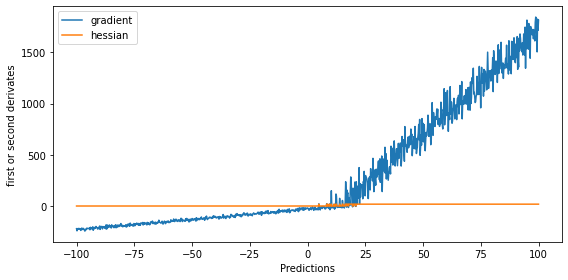

In [54]:
X1, Y1 = make_friedman1(n_samples=1000, n_features=7, noise=0.0, random_state=11)
y_true = Y1
y_pred = np.linspace(-100,100,1000)
grad, hess = custom_asymmetric_objective(y_true, y_pred)

fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.plot(y_pred, grad)
ax.plot(y_pred, hess)
ax.legend(('gradient', 'hessian'))
ax.set_xlabel('Predictions')
ax.set_ylabel('first or second derivates')

fig.tight_layout()

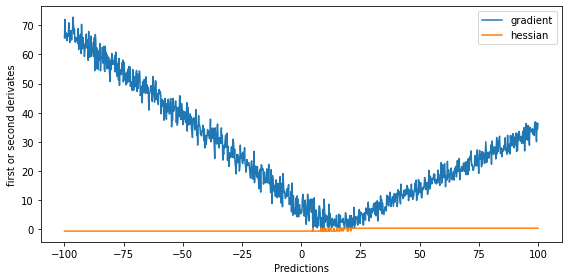

In [59]:
X1, Y1 = make_friedman1(n_samples=1000, n_features=7, noise=0.0, random_state=11)
y_true = Y1
y_pred = np.linspace(-100,100,1000)
# y_pred = model.predict(x)
grad, hess = customLossFunctionTrain(y_true, y_pred)

fig, ax = plt.subplots(1,1, figsize=(8,4))

# ax.plot(y_hat, errors)
ax.plot(y_pred, grad)
ax.plot(y_pred, hess)
ax.legend(('gradient', 'hessian'))
ax.set_xlabel('Predictions')
ax.set_ylabel('first or second derivates')

fig.tight_layout()

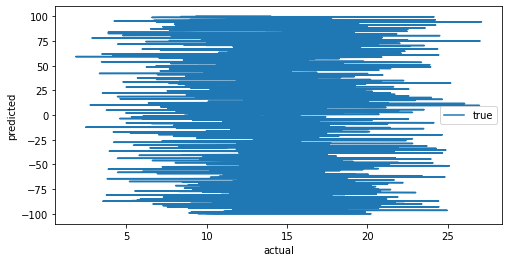

In [45]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(y_true, y_pred)
ax.set_xlabel('actual')
ax.set_ylabel('predicted')
ax.legend(('true', 'false'))
# fig.tight_layout()

In [33]:
y_true[:10], y_pred[:10]

(0    5
 1    4
 2    4
 3    5
 4    4
 5    4
 6    3
 7    3
 8    4
 9    4
 Name: delivery_calendar_days, dtype: int64,
 array([ -94.6832588 ,  -88.14052763,  -77.95208115,  -77.95208115,
         -77.95208115,  -77.95208115,  -77.95208115,  -77.95208115,
        -157.95741785,  -72.60107883]))

In [ ]:
raise

In [ ]:
modes_dict = {}
for col in training_data:
    modes_dict[col] = training_data[col].mode()

In [ ]:
del training_data

In [ ]:
quiz_data = preprocessing.read_data(rows_to_read = N)["quiz"]

quiz_data = preprocessing.parse_datetime_columns(quiz_data)

quiz_data, generated_columns = preprocessing.one_hot_encode_columns(df = quiz_data, columns = cols_to_convert_to_one_hot)


In [ ]:
# Filling in the blanks from non existing 

for col in model.feature_name_:
    if col not in quiz_data.columns:
        print("col : ", col)
        quiz_data[col] = modes_dict[col]

In [ ]:
quiz_data["model_outputs"] = model.predict(quiz_data[cols_to_use])

# Postprocessing

After this is all done and predicting with a decent accuracy this needs to be put back and the output needs to predict the delivery date.

The submission is a tsv table, which can be gzipped, with no headeron thw quiz dataset for now. After we win the first phase the test dataset will be given to us.

Each line should contain two values, first the record identifier from the distributed dataset, which is an integer, and second the predicted delivery date as a string in the format YYYY-MM-DD.

All records must be predicted.

In [ ]:
output_columns_name = "predicted_delivery_date"

In [ ]:
postprocessing.generate_output_column(df = quiz_data, 
                                      predicted_days_column="model_outputs",
                                     output_columns_name = output_columns_name)

In [ ]:
postprocessing.generate_submission_file(df = quiz_data, predicted_dates_column="predicted_delivery_date")

# Double checking outputs

In [ ]:
import pandas as pd

In [ ]:
submission = pd.read_csv("./results/result_2021-12-19 16:59:16.tsv", sep='\t', header = None)

In [ ]:
submission